In [298]:
from sparknlp.base import *
from sparknlp.base import DocumentAssembler
from sparknlp.annotator import *
from sparknlp.pretrained import PretrainedPipeline
import sparknlp
from pyspark.sql.types import ArrayType, DataType, StringType
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark import SparkContext, SQLContext
from nltk.corpus import stopwords
from pyspark.sql.functions import rand
from collections import Counter 
import os
import spacy
from pyspark.ml.feature import HashingTF, IDF, StringIndexer, SQLTransformer,IndexToString
from pyspark.ml.classification import GBTClassifier
from sklearn.metrics import confusion_matrix
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer
from spacy.lang.en.stop_words import STOP_WORDS
from nltk.corpus import stopwords
from unidecode import unidecode
from pyspark.sql.functions import regexp_replace, col, substring, udf
import pyspark.sql.functions as F
import re
import string
import pandas as pd
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import gaussian_gradient_magnitude
import numpy as np
import seaborn as sns
import matplotlib.style as style
from numba import jit, cuda 
import numpy as np 
import numba
import numba.cuda
style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')

In [246]:
# Start Spark Session with Spark NLP
spark = sparknlp.start()
spark = SparkSession.builder.appName("Duda").config("spark.driver.memory","12G").config("spark.memory.offHeap.enabled",True).config("spark.memory.offHeap.size","12G").config("spark.driver.maxResultSize", "10G").config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.11:2.4.5").config("spark.kryoserializer.buffer.max", "1000M").config("spark.network.timeout","3600s").getOrCreate()

In [247]:
stop_words = stopwords.words('english') + list(STOP_WORDS)

# Read Dataset

In [248]:
%%time
# File location and type
file_location = r'dataset/SPAM.csv'
file_type = "csv"# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","
df = spark.read.format(file_type).option("inferSchema", infer_schema).option("header", first_row_is_header).option("sep", delimiter).load(file_location)
# Registers count
df.count()

CPU times: user 0 ns, sys: 15.6 ms, total: 15.6 ms
Wall time: 230 ms


5574

# Basic metrics

In [249]:
%%time
# Check if there are null values
df.filter(df.Message.isNull()).show()

+--------+-------+
|Category|Message|
+--------+-------+
+--------+-------+

CPU times: user 15.6 ms, sys: 0 ns, total: 15.6 ms
Wall time: 86 ms


In [250]:
# Count register per category
df.groupBy(["Category"]).count().show()

+--------+-----+
|Category|count|
+--------+-----+
|     ham| 4827|
|    spam|  747|
+--------+-----+



# Create pipelines for apply text mining techniques

In [283]:
# Assembler
documentAssembler = DocumentAssembler() \
     .setInputCol('Message') \
     .setOutputCol('document_text')

# Tokenizer
tokenizer = Tokenizer() \
     .setInputCols(['document_text']) \
     .setOutputCol('token')

# Cleaner
normalizer = Normalizer() \
     .setInputCols(['token']) \
     .setOutputCol('normalized') \
     .setLowercase(True) 

# Lemmatizer
lemmatizer = LemmatizerModel.pretrained(lang="en") \
     .setInputCols('normalized') \
     .setOutputCol('lemma')

# Stopwords
stopwords_cleaner = StopWordsCleaner() \
     .setInputCols('lemma') \
     .setOutputCol('clean_lemma') \
     .setCaseSensitive(False) \
     .setStopWords(stop_words)

# Ngrams
ngrams_nonCum = NGramGenerator() \
            .setInputCols(["clean_lemma"]) \
            .setOutputCol("ngrams") \
            .setN(3) \
            .setEnableCumulative(False)\
            #.setDelimiter("_") # Default is space

# Concat 
tokenassembler = TokenAssembler()\
    .setInputCols(["document_text", "clean_lemma"]) \
    .setOutputCol("clean_text") \
    .setPreservePosition(False)

# Finisher
finisher = Finisher() \
    .setInputCols(["clean_lemma"]) \
    .setOutputCols(["token_features"]) \
    .setOutputAsArray(True) \
    .setCleanAnnotations(False)# To generate Term Frequency

# To generate Inverse Document Frequency
hashingTF = HashingTF(inputCol="token_features", outputCol="rawFeatures", numFeatures=1000)

# convert labels (string) to integers. Easy to process compared to string
idf = IDF(inputCol="rawFeatures", outputCol="features", minDocFreq=10)

label_stringIdx = StringIndexer(inputCol = "Category", outputCol = "label")

# To convert index(integer) to corresponding class labels
lr = GBTClassifier(maxIter=100)

# define the nlp pipeline
label_to_stringIdx = IndexToString(inputCol="label", outputCol="article_class")

nlp_pipeline = Pipeline(
    stages=[
            documentAssembler,
            tokenizer,
            normalizer,
            lemmatizer,
            stopwords_cleaner,
            ngrams_nonCum,
           tokenassembler,
           finisher,
           hashingTF,
           idf,
           label_stringIdx,
           lr,
           label_to_stringIdx
           ])

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


In [284]:
%%time
#Apply pipeline
df_pipeline = nlp_pipeline.fit(df).transform(df)

CPU times: user 281 ms, sys: 62.5 ms, total: 344 ms
Wall time: 2min 13s


In [254]:
# Visualize an example with a text transformed
df_pipeline.select(['Message']).take(1)

[Row(Message='Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...')]

In [255]:
# Visualize an example with an original text
df_pipeline.select(['clean_text.result']).take(1)

[Row(result=['jurong point crazy available bugis n great world la e buffet cine amore wat'])]

# Create a view in spark to get results and manipulate

In [256]:
# Create a view, on this way we can get just what we need to manipulate
df_pipeline.createOrReplaceTempView("SPAM")

In [257]:
%%time
# Test select
txt = spark.sql('SELECT count(*) as qtd FROM SPAM')
txt.show()

+----+
| qtd|
+----+
|5574|
+----+

CPU times: user 0 ns, sys: 15.6 ms, total: 15.6 ms
Wall time: 172 ms


# Visualize wordcloud for each category

In [258]:
#Function to apply wordcloud
def word_cloud(posts):
    text = " ".join(review for review in posts)
    wc = WordCloud(max_font_size=500,width = 3000, height = 1000, background_color="white").generate(text)
    # plot the WordCloud image  
    plt.figure(figsize = (10,10)) 
    plt.imshow(wc, interpolation="bilinear") 
    plt.axis("off") 
    plt.margins(x=0, y=0) 
    plt.show()

In [259]:
%%time
# Get words results of pipelines and put in pandas dataframe
words = spark.sql('SELECT clean_text.result, category FROM SPAM')
words_df = words.toPandas()

CPU times: user 31.2 ms, sys: 0 ns, total: 31.2 ms
Wall time: 2.71 s


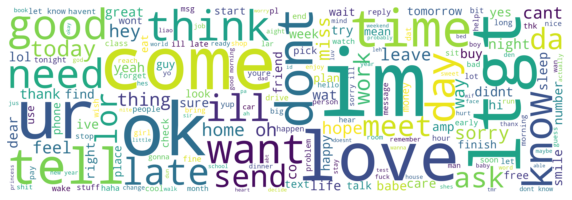

CPU times: user 6.06 s, sys: 281 ms, total: 6.34 s
Wall time: 6.65 s


In [260]:
%%time
# Words where category is ham
word_cloud([sent for txt in words_df[words_df['category'] == 'ham']['result'] for sent in txt])

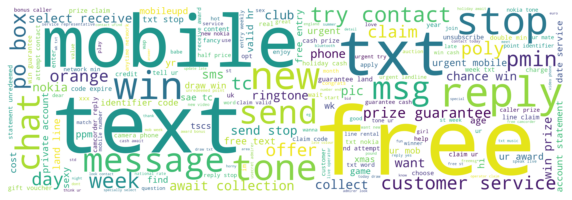

CPU times: user 5.77 s, sys: 172 ms, total: 5.94 s
Wall time: 6.32 s


In [261]:
%%time
# Words where category is spam
word_cloud([sent for txt in words_df[words_df['category'] == 'spam']['result'] for sent in txt])

# Visualize 3-GRAMS

In [262]:
%%time
#Select ngrams from pipelines
ngram = spark.sql('SELECT ngrams.result, category from SPAM')
ngram_df = ngram.toPandas()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 3.11 s


In [263]:
%%time
#Transform it in a dict
ngram_count_ham = dict(Counter([word for arr in ngram_df[ngram_df['category'] == 'ham']['result'] for word in arr]))
ngram_count_spam = dict(Counter([word for arr in ngram_df[ngram_df['category'] == 'spam']['result'] for word in arr]))

CPU times: user 46.9 ms, sys: 0 ns, total: 46.9 ms
Wall time: 40.7 ms


In [264]:
%%time
ngramcount = {}
ngramcount['ham'] = ngram_count_ham
ngramcount['spam'] = ngram_count_spam

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.22 ms


In [265]:
%%time
data_ngram = {}
data_ngram['ham'] ={}
data_ngram['ham']['ngram'] = []
data_ngram['ham']['Count'] = []
data_ngram['spam'] = {}
data_ngram['spam']['ngram'] = []
data_ngram['spam']['Count'] = []

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 493 µs


In [266]:
%%time
for i in ngramcount:
    for k,v in ngramcount[i].items():
        data_ngram[i]['ngram'].append(k)
        data_ngram[i]['Count'].append(v)
        
df_ham = pd.DataFrame(data_ngram['ham'])
df_ham['ham'] = "ham"
df_spam = pd.DataFrame(data_ngram['spam'])
df_spam['spam'] = "spam"
df_ngram = pd.concat([df_ham, df_spam])

CPU times: user 46.9 ms, sys: 0 ns, total: 46.9 ms
Wall time: 91.4 ms


CPU times: user 281 ms, sys: 0 ns, total: 281 ms
Wall time: 356 ms


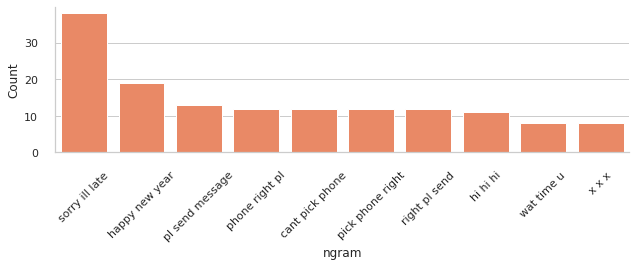

In [267]:
%%time
#Ngrams for ham
sns.set(style="whitegrid")
ax = sns.catplot(x="ngram", y="Count", data=df_ngram[df_ngram['ham'] == "ham"].sort_values(by='Count', ascending=False).head(10), kind = 'bar', color ='coral', orient = 'v', height=3, aspect=3)
ax.set_xticklabels(rotation = 45)

CPU times: user 188 ms, sys: 0 ns, total: 188 ms
Wall time: 317 ms


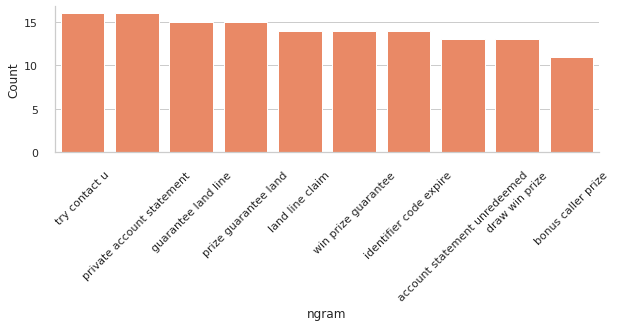

In [268]:
%%time
#Ngrams for spam
sns.set(style="whitegrid")
ax = sns.catplot(x="ngram", y="Count", data=df_ngram[df_ngram['spam'] == "spam"].sort_values(by='Count', ascending=False).head(10), kind = 'bar', color ='coral', orient = 'v', height=3, aspect=3)
ax.set_xticklabels(rotation = 45)

## Check logistc regression results

In [285]:
%%time
# Check accuracy
evaluator_acc =MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")

accuracy_acc = evaluator_acc.evaluate(df_pipeline)
print("Accuracy = %g" % (accuracy_acc))
print("Test Error = %g " % (1.0 - accuracy_acc))

Accuracy = 0.99103
Test Error = 0.00897022 
CPU times: user 0 ns, sys: 15.6 ms, total: 15.6 ms
Wall time: 4.72 s


In [286]:
%%time
# Check precision
evaluator_p = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
accuracy_p = evaluator_p.evaluate(df_pipeline)
print("Accuracy = %g" % (accuracy_p))
print("Test Error = %g " % (1.0 - accuracy_p))

Accuracy = 0.991122
Test Error = 0.00887825 
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.93 s


In [305]:
# Confusion matrix
y_true = df_pipeline.select("label")
y_true = y_true.toPandas()

y_pred = df_pipeline.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred)

In [315]:
confusion_matrix = pd.DataFrame(cnf_matrix, columns = ['ham', 'spam'])
confusion_matrix['Predictors'] = ['ham', 'spam']
confusion_matrix.set_index('Predictors')

,ham,spam
Predictors,,
ham,4827,0
spam,50,697
